In [1]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import cupy,tqdm # CUDA interface for python
%load_ext autoreload
%autoreload 2
%load_ext autotime

In [2]:
a = sciIO.readsav('../B0.sav')
print(a.keys())

C:\Users\Pjer1\Anaconda3\envs\torch15\lib\site-packages\scipy\io\idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


dict_keys(['twbox'])
time: 2.41 s


In [3]:
# need to be transposed because of the storage toplogy
Bx = np.transpose(a.twbox[0].bx,(2,1,0)).astype(np.float32)
By = np.transpose(a.twbox[0].by,(2,1,0)).astype(np.float32)
Bz = np.transpose(a.twbox[0].bz,(2,1,0)).astype(np.float32)
#Bx = np.transpose(a.bx,(2,1,0)).astype(np.float32)
#By = np.transpose(a.by,(2,1,0)).astype(np.float32)
#Bz = np.transpose(a.bz,(2,1,0)).astype(np.float32)
(Bx_gpu,By_gpu,Bz_gpu) = [np.zeros(0) for _ in range(3)]; flag_init=False
#plt.imshow(Bz[:,:,50].T) 

time: 1.37 s


In [4]:
import os
print('compiling kernel')
PWD = os.getcwd()
traceFunc_file = open("TraceBlineAdaptive.cu", "rt")
TraceFunc =cupy.RawModule(code=traceFunc_file.read(),backend='nvcc',options=("-I "+PWD,))#, include_dirs=[PWD], cache_dir='cache',no_extern_c=True)
TraceAllBline = TraceFunc.get_function("TraceAllBline")

if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = cupy.array(Bx)
    By_gpu = cupy.array(By)
    Bz_gpu = cupy.array(Bz)
    

dummy=cupy.zeros([1,1],dtype=cupy.float32)
flag_twist=cupy.array([False],dtype=cupy.bool_)

compiling kernel
transfering B-field to GPU
time: 9.69 s


In [6]:
import FastQSL
# prepare variables
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx.shape
print(BshapeN)
BshapeN = cupy.array(BshapeN)

interp_ratio=3
stride_step=1/interp_ratio
x_range = [0,1163]
y_range = [0,487]
x_range = [360,660]
y_range = [230,410]
z_range = [0,120]

x_i = cupy.linspace(*x_range, np.uint(interp_ratio*(x_range[1]-x_range[0])),dtype=cupy.float32)
y_i = cupy.linspace(*y_range, np.uint(interp_ratio*(y_range[1]-y_range[0])),dtype=cupy.float32)
z_i = cupy.linspace(*z_range, np.uint(interp_ratio*(z_range[1]-z_range[0])),dtype=cupy.float32)

x_arr,y_arr = cupy.meshgrid(x_i, y_i,indexing='ij')

xy_shape = x_arr.shape

x_inp = x_arr.flatten()
y_inp = y_arr.flatten()

#z_inp[:] = +23.583333

if not flag_init:
    (x_start,y_start,z_start, x_end,y_end,z_end,
     Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
    )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]

    (B_flag,flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]
    flag_init=True

line_len = cupy.zeros(x_inp.shape,cupy.float64)
N        = cupy.array([x_inp.shape[0]],cupy.ulonglong)
s_len    = cupy.array([1./8.],cupy.float32)
tol_coef    = cupy.array([10.],cupy.float32)


inp_norm = cupy.array([0,0,1.],cupy.float32)

# for GTX 1060
#blck=(64,1,1)
#grd = (20,1)

# for GTX1080ti
blck=(128,1,1)
grd = (28,1)
cupy.cuda.stream.get_current_stream().synchronize()

[1164  488  488]
time: 12 ms


In [7]:
Qube=np.zeros([*xy_shape,z_i.shape[0]],dtype=np.float32)
#z_i=z_i*0+20

time: 983 µs


In [9]:
B_bottom_z0=cupy.zeros_like(x_arr);

time: 2 ms


In [10]:
pinned_mempool = cupy.get_default_pinned_memory_pool()
for idx_pos_z,z_pos in tqdm.tqdm(enumerate(z_i)):
    
    x_inp = x_arr.flatten()
    y_inp = y_arr.flatten()
    z_inp = (cupy.zeros_like(x_inp,cupy.float32)+z_pos)
    
    (x_start,y_start,z_start, x_end,y_end,z_end,
         Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
        )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]

    (B_flag,flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]
    
    cupy.cuda.stream.get_current_stream().synchronize()
    # run the big calclation
    TraceAllBline(blck,grd,
                (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
              dummy,dummy,dummy,dummy,flag_twist,
                x_inp,   y_inp,   z_inp,inp_norm,
                x_start, y_start, z_start, flag_start,
                x_end,   y_end,   z_end,   flag_end,
                Bx_inp,  By_inp,  Bz_inp,  B_flag,
                Bx_start,By_start,Bz_start,
                Bx_end,  By_end,  Bz_end,  
                s_len,N,line_len, tol_coef*0.3))
    
    cupy.cuda.stream.get_current_stream().synchronize()
    (x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
     x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
     Bx_in_arr,   By_in_arr,  Bz_in_arr,
     Bx_out_arr,  By_out_arr, Bz_out_arr,
     Bx_0_arr,    By_0_arr,   Bz_0_arr,   B_flag_arr) = FastQSL.ResReshape(xy_shape,
                    x_end,y_end,z_end,flag_end,
                    x_start,y_start,z_start,flag_start,
                    Bx_start,By_start,Bz_start,
                    Bx_end,By_end,Bz_end, 
                    Bx_inp,By_inp,Bz_inp,B_flag)
    
    if idx_pos_z==0:
        B_bottom_z0=Bz_0_arr
        
    cupy.cuda.stream.get_current_stream().synchronize()
    Q=FastQSL.QCalcPlane(x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
         x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
         Bx_in_arr,   By_in_arr,  Bz_in_arr,
         Bx_out_arr,  By_out_arr, Bz_out_arr,
         Bx_0_arr,    By_0_arr,   Bz_0_arr,    
         B_flag_arr, stride_step)
    stride_this  =  cupy.float32(1./interp_ratio)/8

    (cut_inp_x,   cut_inp_y,   cut_inp_z,
        cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
        cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
        Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
        Bx_start_cut,By_start_cut,Bz_start_cut,
        Bx_end_cut,  By_end_cut,  Bz_end_cut,  
        N_cut,line_len_cut,Bz0_start, Bz0_end)=FastQSL.CookPseudoLine(
             x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
             x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
             Bx_in_arr,   By_in_arr,  Bz_in_arr,
             Bx_out_arr,  By_out_arr, Bz_out_arr,
             Bz_0_arr,    B_flag_arr, stride_this)
    
    cupy.cuda.stream.get_current_stream().synchronize()
    TraceAllBline(blck,grd,
            (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
              dummy,dummy,dummy,dummy,flag_twist,
            cut_inp_x,   cut_inp_y,   cut_inp_z,inp_norm,
            cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
            cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
            Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
            Bx_start_cut,By_start_cut,Bz_start_cut,
            Bx_end_cut,  By_end_cut,  Bz_end_cut,  
            s_len,N_cut,line_len_cut, tol_coef*.1))
    
    
    cupy.cuda.stream.get_current_stream().synchronize()
    (X1,Y1,X2,Y2) = [cupy.zeros(cut_inp_x.shape,dtype=cupy.float32) 
                     for _ in range(4)];

    idx_Z1_cut=(flag_cut_start-1)//2 == 2;  idx_Z2_cut=(flag_cut_end-1)//2 == 2
    idx_Y1_cut=(flag_cut_start-1)//2 == 1;  idx_Y2_cut=(flag_cut_end-1)//2 == 1
    idx_X1_cut=(flag_cut_start-1)//2 == 0;  idx_X2_cut=(flag_cut_end-1)//2 == 0

    
    cupy.cuda.stream.get_current_stream().synchronize()
    # Z plane
    X1[idx_Z1_cut] = cut_start_x[idx_Z1_cut]; Y1[idx_Z1_cut] = cut_start_y[idx_Z1_cut] 
    X2[idx_Z2_cut] = cut_end_x[idx_Z2_cut];   Y2[idx_Z2_cut] = cut_end_y[idx_Z2_cut] 
    # Y plane
    X1[idx_Y1_cut] = cut_start_z[idx_Y1_cut]; Y1[idx_Y1_cut] = cut_start_x[idx_Y1_cut]
    X2[idx_Y2_cut] = cut_end_z[idx_Y2_cut];   Y2[idx_Y2_cut] = cut_end_x[idx_Y2_cut]
    # X plane
    X1[idx_X1_cut] = cut_start_y[idx_X1_cut]; Y1[idx_X1_cut] = cut_start_z[idx_X1_cut]
    X2[idx_X2_cut] = cut_end_y[idx_X2_cut];   Y2[idx_X2_cut] = cut_end_z[idx_X2_cut]

    dx2xc = X2[0::4]-X2[2::4]; dx2yc = X2[1::4]-X2[3::4];
    dy2xc = Y2[0::4]-Y2[2::4]; dy2yc = Y2[1::4]-Y2[3::4];
    dx1xc = X1[0::4]-X1[2::4]; dx1yc = X1[1::4]-X1[3::4];
    dy1xc = Y1[0::4]-Y1[2::4]; dy1yc = Y1[1::4]-Y1[3::4];
    a_cut = (dx2xc*dy1yc-dx2yc*dy1xc);
    b_cut = (dx2yc*dx1xc-dx2xc*dx1yc);
    c_cut = (dy2xc*dy1yc-dy2yc*dy1xc);
    d_cut = (dy2yc*dx1xc-dy2xc*dx1yc);

    bnr_cut = cupy.abs(Bz0_end)/(cupy.abs(Bz0_start))*((1/stride_this/2)**4)
    Qcut = (a_cut**2+b_cut**2+c_cut**2+d_cut**2)*bnr_cut
    Qcut[cupy.where(Qcut<1.0)]=1.0
    
    Q_all=cupy.zeros(x_end_arr.shape,dtype=cupy.float32)
    Q_all[1:-1,1:-1]=Q
    Q_all[B_flag_arr==1]=Qcut
    
    Qube[:,:,idx_pos_z]=Q_all.get()
    cupy.cuda.stream.get_current_stream().synchronize()
    
    (x_start,y_start,z_start, x_end,y_end,z_end,z_inp,
         Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
        )=[None for _ in range(16)]
    (B_flag,flag_start,flag_end)=[None for _ in range(3)]
    pinned_mempool.free_all_blocks()

360it [01:47,  3.34it/s]

time: 1min 47s


In [9]:
import plotly
x_i_0 = np.linspace(*x_range, np.uint(interp_ratio*(x_range[1]-x_range[0])),dtype=np.float32)
y_i_0 = np.linspace(*y_range, np.uint(interp_ratio*(y_range[1]-y_range[0])),dtype=np.float32)
z_i_0 = np.linspace(*z_range, np.uint(interp_ratio*(z_range[1]-z_range[0])),dtype=np.float32)

x_arr_0,y_arr_0,z_arr_0 = np.meshgrid(x_i_0, y_i_0, z_i_0,indexing='ij')

time: 1.47 s


In [11]:
Qube.shape

(900, 540, 360)

time: 5.02 ms


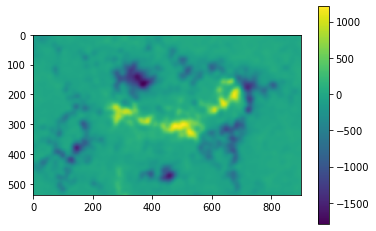

time: 437 ms


In [11]:
plt.imshow(B_bottom_z0.get().T)
plt.colorbar()

In [12]:
from numpy import cos, pi, mgrid
import pyvista as pv

time: 1.84 s


In [14]:
np.savez('../QubePOT.npz', Qube=Qube,xi=x_i_0,yi=y_i_0,zi=z_i_0,
        Bz0=B_bottom_z0)

time: 1.57 s


In [3]:
import numpy as np
with np.load('../QubePOT.npz') as data:
    Qube = data['Qube']
    Bz0 = data['Bz0']
    xi = data['xi']
    yi = data['yi']
    zi = data['zi']

In [5]:
Qube.shape

(900, 540, 360)

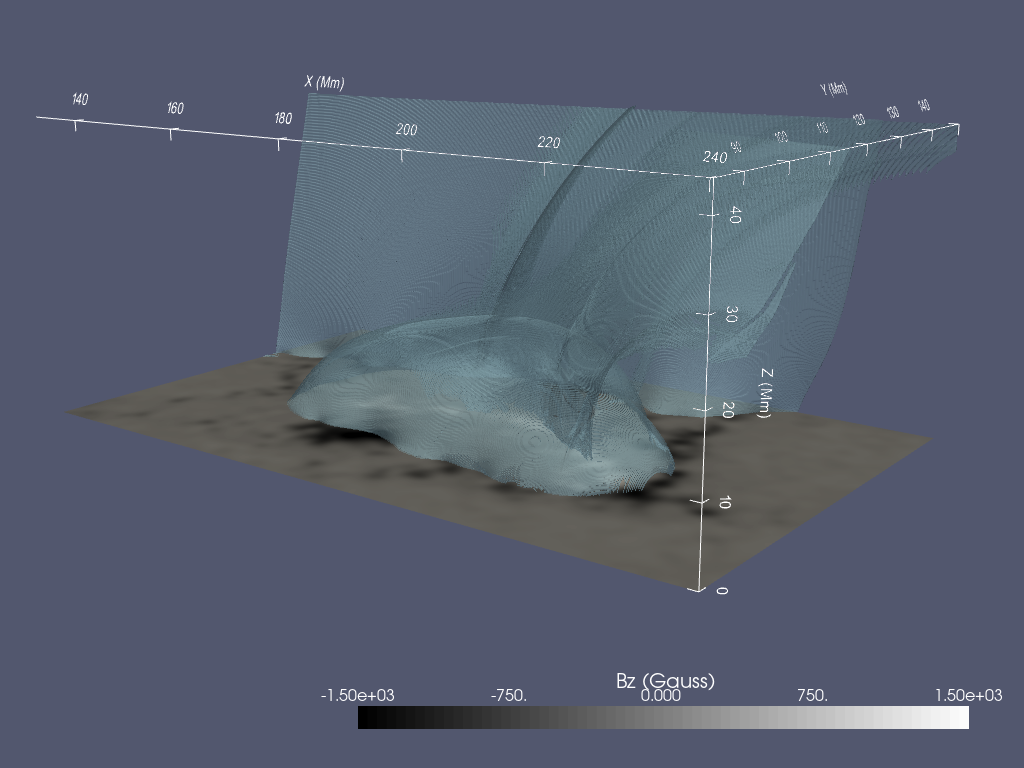

None
time: 26.4 s


In [20]:
import numpy as np
import pyvista as pv

axis_r = 0.364257

xx2,yy2 = np.meshgrid(x_i_0*axis_r, y_i_0*axis_r,indexing='ij')
zz2 = np.zeros_like(xx2)
B0mesh = pv.StructuredGrid(xx2, yy2, zz2)

xx3,yy3,zz3 = np.meshgrid(x_i_0*axis_r, y_i_0*axis_r, z_i_0*axis_r,indexing='ij')
grid = pv.StructuredGrid(xx3, yy3, zz3)
grid["vol"] = Qube.T.flatten()
contours = grid.contour([40000])

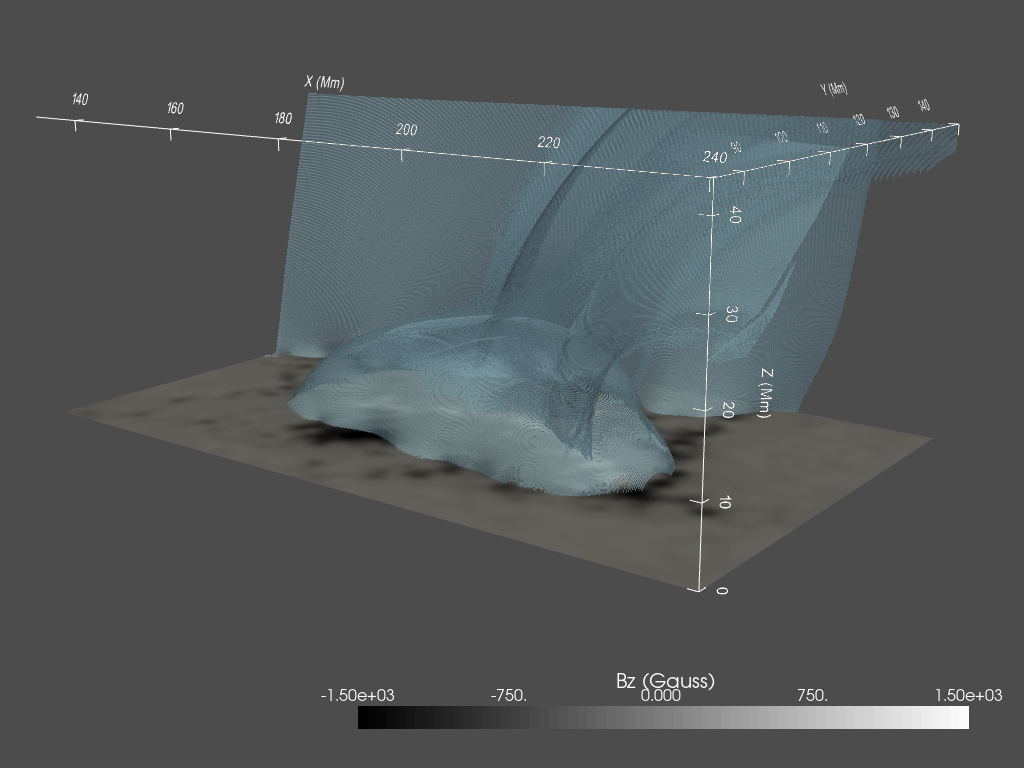

time: 8.38 s


In [25]:
p = pv.Plotter()
pv.set_plot_theme("default")
largest = contours.connectivity(largest=True)
surf = largest.extract_geometry()
#9ac4d9
p.add_mesh(surf, color='#9ac4d9', smooth_shading=True,opacity=0.4 )
sargs = dict(height=0.25, vertical=True, position_x=0.05, position_y=0.05)
p.add_mesh(B0mesh,scalars=B_bottom_z0.get().T, cmap='gray',clim=[-1500,1500], scalar_bar_args=sargs)
#p.enable_eye_dome_lighting()
#p.add_mesh(surf.outline(), color="k")
p.camera_position =[(309.21929818544663, -39.476961535608346, 62.5609895585235),
 (206.8292875784721, 95.43630460720914, 14.52431785900496),
 (-0.16273952375365774, 0.21903523353563947, 0.9620495901347398)]
p.add_scalar_bar(title='Bz (Gauss)',title_font_size=20)
p.show_bounds( xlabel='X (Mm)', ylabel='Y (Mm)', zlabel='Z (Mm)',)
pv.set_plot_theme("default")

p.show()

In [21]:
a


time: 0 ns


In [ ]:
opacity = [ 0,0.3,0.5, 0.65, 0.8]
clim = [1000, 40000]

p = pv.Plotter()
p.add_volume(Qube, cmap="magma", clim=clim,
             opacity=opacity, opacity_unit_distance=2,)
p.camera_position = [(-800*2, 1200*2, 666*2),
 (179.5, 299.5, 99.5),
 (0.4, -0.1, 0.9)]
p.show()

In [ ]:
#%% Data
grid = pv.StructuredGrid(x_arr_0.flatten(), y_arr_0.flatten(), z_arr_0.flatten())
grid["vol"] = Qube.flatten()
contours = grid.contour([1000000])

#%% Visualization
pv.set_plot_theme('document')
p = pv.Plotter()
p.add_mesh(contours, scalars=contours.points[:, 2], show_scalar_bar=False)
p.show()

In [ ]:
plt.close()

xxlim=None
yylim=None

#xxlim=[400,720]
#yylim=[150,400]
#xxlim=[550,650]
#yylim=[200,270]
#xxlim= [350,670]
#yylim= [200,400]

dpi=180

fig=plt.figure(0,dpi=dpi); ax = plt.gca() 
img=ax.imshow(flag_start_arr.get(),cmap='inferno',origin='lower',vmin=0,
              extent=[*x_range,*y_range],vmax=6)
fig.colorbar(img)
ax.set_title('flag')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(1,dpi=dpi); ax = plt.gca() 
img=ax.imshow((line_len.get().reshape(xy_shape)),cmap='inferno',origin='lower',
              vmin=0,extent=[*x_range,*y_range],vmax=1000)
fig.colorbar(img)
ax.set_title('Length of B-line')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(2,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_in_arr.get()/Bz_out_arr.get(),cmap='gray',origin='lower',
              vmax=10,vmin=-10,extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_in')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_out_arr.get(),cmap='gray',origin='lower',vmax=1000,vmin=-1000,
              extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_out')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(4,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q.get())*np.sign(Bz_0_arr.get()[1:-1,1:-1])
                *(flag_start_arr.get()[1:-1,1:-1]<=6),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',
                extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


fig=plt.figure(5,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q.get())*np.sign(Bz_0_arr.get()[1:-1,1:-1])
                *(flag_start_arr.get()[1:-1,1:-1]<=6),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',
                extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(6,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q_all.get())*(flag_start_arr.get()[1:-1,1:-1]<41),
                vmax=5,vmin=0,cmap='gray_r',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map-gray')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


In [ ]:
fig=plt.figure(1,dpi=180); ax = plt.gca() 
#img = ax.imshow(np.log((b.get())**2),cmap='inferno',origin='lower',extent=[*x_range,*y_range])
#fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=180); ax = plt.gca() 
img = ax.imshow((B_flag_arr.get()),cmap='inferno',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)
